# Vaccination Tweets

Measuring attitude: how many people tweet by population, how many by population tweet about vaccines, how well are vaccinations monitored

Sentiment analysis
factual statements (neutral, topic related), evaluative statements (attitude)

Find a measure of weighted sentiment.
Twitter dynamics: check for balance of sentiment among influential sources

Relate sentiment to retweets, likes

To which degree do verified sources express or promote evaluative stances (especially medical and scientific institutions?)

How many uses tweet repetivitely?  If they do, they influence the result of a sentiment analysis more strongly

In [7]:
# Main data packages. 
import numpy as np
import pandas as pd
from datetime import datetime

#NLP modules
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
#nltk.download('punkt')
#nltk.download('wordnet')

In [40]:
df = pd.read_csv("Data/vaccination_tweets.csv")

In [41]:
df_tweety = df.copy()

In [42]:
shape = df_tweety.shape
print('The unmodified vaccination tweets dataset contains {} columns and {} rows.'.format(shape[1], shape[0]))

The unmodified vaccination tweets dataset contains 16 columns and 38547 rows.


In [43]:
#df_tweety.head(100)

In [44]:
df_tweety.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38547 entries, 0 to 38546
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                38547 non-null  int64 
 1   user_name         38547 non-null  object
 2   user_location     29767 non-null  object
 3   user_description  35940 non-null  object
 4   user_created      38547 non-null  object
 5   user_followers    38547 non-null  int64 
 6   user_friends      38547 non-null  int64 
 7   user_favourites   38547 non-null  int64 
 8   user_verified     38547 non-null  bool  
 9   date              38547 non-null  object
 10  text              38547 non-null  object
 11  hashtags          30330 non-null  object
 12  source            38514 non-null  object
 13  retweets          38547 non-null  int64 
 14  favorites         38547 non-null  int64 
 15  is_retweet        38547 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 4.2+ MB


In [45]:
df_tweety.describe().round(2)

,id,user_followers,user_friends,user_favourites,retweets,favorites
count,3.854700e+04,38547.00,38547.00,38547.00,38547.00,38547.00
mean,1.365051e+18,109675.74,1309.57,15013.42,3.11,13.75
std,8.619936e+15,882398.75,6020.04,41677.98,33.87,184.20
min,1.337728e+18,0.00,0.00,0.00,0.00,0.00
25%,1.362003e+18,120.00,144.00,360.00,0.00,0.00
50%,1.366887e+18,577.00,417.00,2146.00,0.00,1.00
75%,1.371547e+18,2780.50,1189.00,11272.00,1.00,4.00
max,1.375348e+18,14906907.00,380428.00,1205878.00,2360.00,22815.00


In [46]:
df_tweety.isnull().sum()

id                     0
user_name              0
user_location       8780
user_description    2607
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            8217
source                33
retweets               0
favorites              0
is_retweet             0
dtype: int64

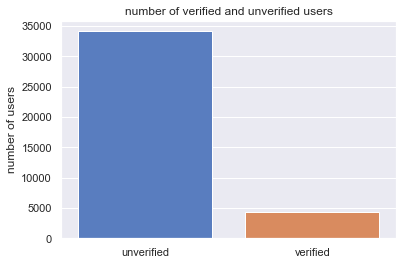

From 38547 accounts, 11.37% are verified twitter accounts.


In [47]:
sns.set_theme()
sns.set_palette('muted')
#Print users (verified/unverified), "verified" meaning that they are recognized to have some sort of official character
ax = sns.countplot(x='user_verified', data=df_tweety)
ax.set(xlabel='', ylabel='number of users', title='number of verified and unverified users')
plt.xticks(ticks=[False,True], labels=['unverified','verified'])
plt.show()
print(f'From {df_tweety.shape[0]} accounts, {round(df_tweety.user_verified.mean()*100, 2)}% are verified twitter accounts.')

In [48]:
#No tweets in this dataset appear to be retweets
df_tweety["is_retweet"].unique()

array([False])

In [49]:
#Insert column 'day' to map the vaccination progress data set
df_tweety['day'] = pd.to_datetime(df_tweety.date).dt.date

In [50]:
df_tweety.dtypes

id                   int64
user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
retweets             int64
favorites            int64
is_retweet            bool
day                 object
dtype: object

### Dropping stuff(?)

In [51]:
#The below mentioned columns should be dropped
#df_tweety.drop(['user_description', 'user_created', 'user_location', user_name', 'is_retweet', 'source'], axis=1)

In [52]:
#There are duplicates in the text section, however, they ... check if source identical, there are no retweets, maybe duplicates should be removed in order to prevent imbalance
df_tweety[(df_tweety.duplicated(subset=['text', 'user_name'], keep=False))]

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,day
2789,1347977910628487170,Anees انيس M.D.,"Portland,OR🏠 / Chino, CA 🏥",39 | Muslim | Blazermaniac | OES & Reed Colleg...,2011-04-18 21:00:35,645,1023,66595,False,2021-01-09 18:45:52,So yesterday was rough - fatigue headache and ...,['PfizerBioNTech'],Twitter for Android,1,4,False,2021-01-09
2790,1347977793305407490,Anees انيس M.D.,"Portland, OR 🏠 / Chino, CA 🏥",39 | American Muslim | Indian descent | M.D | ...,2011-04-18 21:27:09,1168,1147,73118,False,2021-01-09 18:45:24,So yesterday was rough - fatigue headache and ...,['PfizerBioNTech'],Twitter for Android,0,2,False,2021-01-09
2827,1347916046225854465,The National,"Abu Dhabi, UAE","The official Twitter feed of The National, the...",2009-02-11 11:34:06,1034797,196,3240,True,2021-01-09 14:40:03,#Dubai opens seventh clinic for Covid-19 #Pfiz...,"['Dubai', 'PfizerBioNTech']",Hootsuite Inc.,3,11,False,2021-01-09
2997,1348152601897009153,The National,"Abu Dhabi, UAE","The official Twitter feed of The National, the...",2009-02-11 11:34:06,1035023,197,3245,True,2021-01-10 06:20:02,#Dubai opens seventh clinic for Covid-19 #Pfiz...,"['Dubai', 'PfizerBioNTech']",Hootsuite Inc.,5,21,False,2021-01-10
3952,1351462710999965697,Lovin Dubai | لوڤن دبي,"Dubai, United Arab Emirates",Lovin’ Dubai captures the best of the world ar...,2009-02-17 10:25:01,254712,1494,5594,True,2021-01-19 09:33:13,Vaccinated and ready to dominate the world onc...,"['dubai', 'dha', 'vaccine', 'PfizerBioNTech']",Twitter Web App,0,4,False,2021-01-19
4112,1352672804475465728,TheRag,Ragbag Of Reviews And Insights,siya@mmvii.co.za/heelextension@gmail.com,2019-02-11 18:11:23,487,5003,65,False,2021-01-22 17:41:42,#Covid19 Vaccine Rollout Needs Spark Even More...,"['Covid19', 'Ergotron', 'VaccinationCart', 'Pf...",Twitter Web App,1,0,False,2021-01-22
4116,1352351457597657088,TheRag,Ragbag Of Reviews And Insights,siya@mmvii.co.za/heelextension@gmail.com,2019-02-11 18:11:23,487,5003,65,False,2021-01-21 20:24:47,#Covid19 Vaccine Rollout Needs Spark Even More...,"['Covid19', 'Ergotron', 'VaccinationCart', 'Pf...",Twitter Web App,1,0,False,2021-01-21
4360,1352647210366861313,Lovin Dubai | لوڤن دبي,"Dubai, United Arab Emirates",Lovin’ Dubai captures the best of the world ar...,2009-02-17 10:25:01,254854,1495,5598,True,2021-01-22 16:00:00,Vaccinated and ready to dominate the world onc...,"['dubai', 'dha', 'vaccine', 'PfizerBioNTech']",TweetDeck,1,3,False,2021-01-22
4499,1353407921665826816,TheRag,Ragbag Of Reviews And Insights,siya@mmvii.co.za/heelextension@gmail.com,2019-02-11 18:11:23,485,5004,67,False,2021-01-24 18:22:48,#Covid19 Vaccine Rollout Needs Spark Even More...,"['Covid19', 'Ergotron', 'VaccinationCart', 'Pf...",Twitter Web App,1,0,False,2021-01-24
4531,1353959514614202368,TheRag,Ragbag Of Reviews And Insights,siya@mmvii.co.za/heelextension@gmail.com,2019-02-11 18:11:23,484,5004,70,False,2021-01-26 06:54:38,#Covid19 Vaccine Rollout Needs Spark Even More...,"['Covid19', 'Ergotron', 'VaccinationCart', 'Pf...",Twitter Web App,1,0,False,2021-01-26


In [53]:
#create dataframes for subcategories
df = df_tweety[(df_tweety["user_followers"]>=10)]# & (df_tweety["user_verified"]==True)] (df_tweety["user_followers"]>=10)

In [54]:
# Users tweet repeptitively. About a third of users tweet repetitively. Assuming that their sentiment does not change, their sentiment is amplified.
(len(df_tweety) - df_tweety.user_name.nunique())/len(df_tweety)

0.4389187225983864

/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


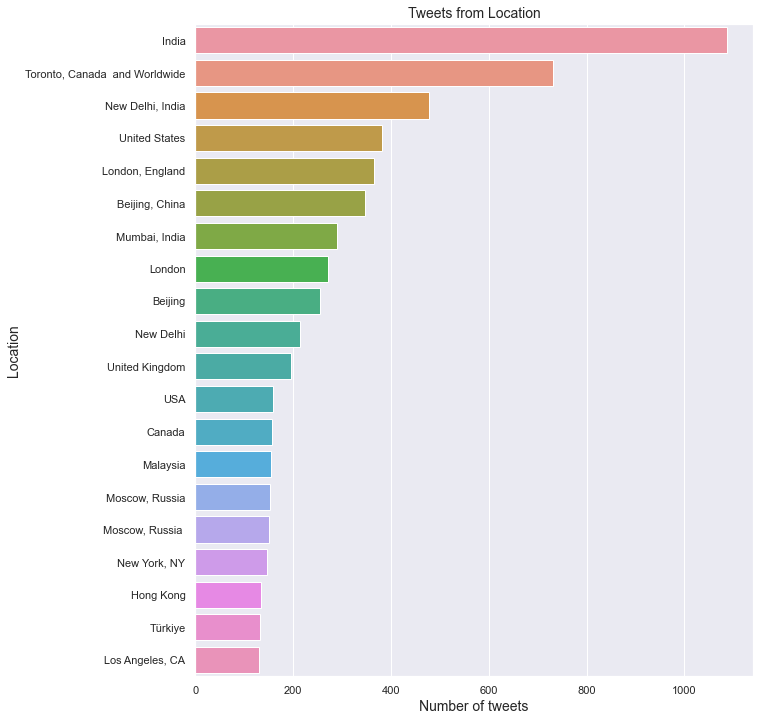

In [55]:
#user_location columns is useless!
plt.figure(figsize=(10,12))
sns.barplot(df_tweety["user_location"].value_counts().values[0:20],
            df_tweety["user_location"].value_counts().index[0:20]);
plt.title("Tweets from Location",fontsize=14)
plt.xlabel("Number of tweets",fontsize=14)
plt.ylabel("Location",fontsize=14)
plt.show()

## Best Tweets

In [56]:
# Total tweets
print('Total tweets this period:', len(df_tweety.index), '\n')

# Retweets
df_tweety_stat = df.sort_values(by='retweets', ascending=False)
print('Mean retweets:', round(df_tweety_stat['retweets'].mean(),2), '\n')

print('10 most responded tweets')
print('------------------')
print(df_tweety['text'].iloc[:10], '\n')
    
# Likes
df_tweety_stat = df.sort_values(by='user_favourites', ascending=False)
print('Mean likes:', round(df_tweety_stat['user_favourites'].mean(),2), '\n')
print('10 most liked tweets')
print('-------------------')
print(df_tweety['text'].iloc[:10], '\n')

Total tweets this period: 38547 

Mean retweets: 3.25 

10 most responded tweets
------------------
0    Same folks said daikon paste could treat a cyt...
1    While the world has been on the wrong side of ...
2    #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3    Facts are immutable, Senator, even when you're...
4    Explain to me again why we need a vaccine @Bor...
5    Does anyone have any useful advice/guidance fo...
6    it is a bit sad to claim the fame for success ...
7    There have not been many bright days in 2020 b...
8    Covid vaccine; You getting it?\n\n #CovidVacci...
9    #CovidVaccine \n\nStates will start getting #C...
Name: text, dtype: object 

Mean likes: 15767.46 

10 most liked tweets
-------------------
0    Same folks said daikon paste could treat a cyt...
1    While the world has been on the wrong side of ...
2    #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3    Facts are immutable, Senator, even when you're...
4    Explain to me again why we need a

## Tweets data cleaning

In [57]:
import string

In [58]:
#remove twitter handlers
df_tweety.text = df_tweety.text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\B#\S+','',x))

#remove URLs
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'http\S+', '', x))

#remove punctuation
df_tweety.text = df_tweety.text.apply(lambda x:x.replace('[^\w\s]',''))

#remove special characters
df_tweety.text = df_tweety.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove single characters
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

#substitute multiple spaces with single space
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

#lowercase
df_tweety.text = df_tweety.apply(lambda x: ' '.join([word.upper() for word in x.split()] ))

AttributeError: 'Series' object has no attribute 'split'

In [59]:
#remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
df_tweety.text = df_tweety.text.apply(lambda x:' '.join([word for word in x.split() if word not in stopwords]))

In [60]:
#tokenize
#df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([word_tokenize(word) for word in x.split() ]))

In [61]:
# stemming 
stemmer = PorterStemmer()
df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split() ]))

In [62]:
# lemmazation
lemmatizer = WordNetLemmatizer()
df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() ]))

In [25]:
#remove abbreviations
import csv

In [ ]:
def translator(user_string):
    user_string = user_string.split(" ")
    j = 0
    for _str in user_string:
        # File path which consists of Abbreviations.
        fileName = "/Users/JDSeo/Desktop/Daily-Neural-Network-Practice-2/NLP/cleaning/slang.txt"
        with open(fileName, "r") as myCSVfile:
            # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
            dataFromFile = csv.reader(myCSVfile, delimiter="=")
            # Removing Special Characters.
            _str = re.sub('[^a-zA-Z0-9]+', '', _str)
            for row in dataFromFile:
                # Check if selected word matches short forms[LHS] in text file.
                if _str.upper() == row[0]:
                    # If match found replace it with its appropriate phrase in text file.
                    user_string[j] = row[1]
            myCSVfile.close()
        j = j + 1
    return ' '.join(user_string)

In [63]:
df_tweety

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,day
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folk said daikon past could treatcytokin ...,['PfizerBioNTech'],Twitter for Android,0,0,False,2020-12-20
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,while world wrong side histori year hope bigge...,NaN,Twitter Web App,1,1,False,2020-12-13
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,russian vaccin creat last 2 4 year,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,2020-12-12
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,fact immut senat even ethic sturdi enough ackn...,NaN,Twitter Web App,446,2129,False,2020-12-12
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain needvaccin,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,2020-12-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38542,1372433256537235459,Rising Bharat,Village,Bharat is Rising,2021-03-02 08:31:23,625,0,0,False,2021-03-18 06:22:41,the sputniki review emerg use author india It ...,NaN,Twitter Web App,1,7,False,2021-03-18
38543,1372430850982350853,Bright Uzbekistan,Uzbekistan,Bright Uzbekistan is a new International magaz...,2021-01-11 09:21:03,18,182,59,False,2021-03-18 06:13:08,IT IS plan TO start mass vaccin IN uzbekistan ...,NaN,Twitter Web App,0,0,False,2021-03-18
38544,1372428007403585538,Sputnik V,"Moscow, Russia",Sputnik V is the world’s first registered COVI...,2020-08-11 09:12:38,223700,142,678,True,2021-03-18 06:01:50,austrian chancellor sebastian kurz concern vac...,['SputnikV'],Twitter for iPhone,83,226,False,2021-03-18
38545,1372419998250115078,Sputnik,NaN,"Sputnik is a global wire, radio and digital ne...",2009-04-22 12:55:28,322326,306,24,True,2021-03-18 05:30:00,norwegian politician call cut vaccin deal amid...,['SputnikV'],TweetDeck,6,16,False,2021-03-18


In [104]:
#It does not look like it makes sense to differentiate between user locations
df_tweety.user_location.nunique()

2151

# Progress Dataset

In [ ]:
df_prog = pd.read_csv("Data/country_vaccinations.csv")

In [ ]:
df_prog.info()

In [ ]:
df_prog.head()

In [ ]:
df_prog["vaccines"].unique()